# Fourier features to capture seasonality

In this notebook we will show...

In [1]:
import re
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "date_time"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

In [3]:
data.shape

(115368, 1)

The data is relatively large compared to the other datasets we have been working with. If the rest of this notebook runs too slowly on your laptop try filtering to a recent segment of the data. For example by running:

```Python
# Filter to the previous 3 years of the dataset
data = data.loc["2012":]
```

## Plot the data

There time series is high frequency and over a long period. Let's plot the previous three years.

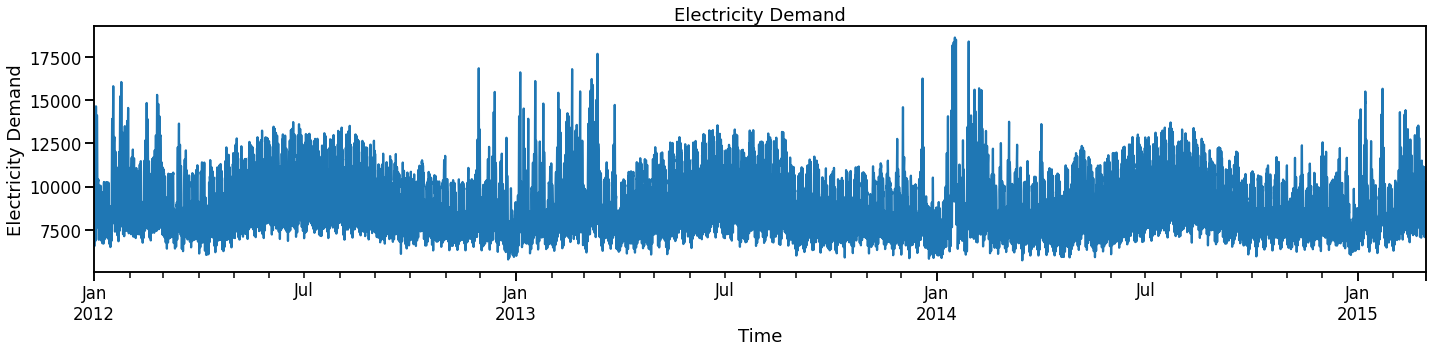

In [4]:
fig, ax = plt.subplots(figsize=[20, 5])
data.loc["2012":].plot(y="demand", legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Demand")
ax.set_title("Electricity Demand")
plt.tight_layout()

# Creating fourier features with sktime

In [5]:
from sktime.transformations.series.fourier import FourierFeatures

In [6]:
transformer = FourierFeatures(
                              sp_list = [24, 24*7], # list of seasonal periods
                              fourier_terms_list = [3, 3], # list of fourier terms
                              freq="H", # Frequency of the time series
                              keep_original_columns=False,
                             )

transformer.fit(data) 
result = transformer.transform(data)
result.head()

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/fourier.py:124: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_168_1,cos_168_1,sin_168_2,cos_168_2,sin_168_3,cos_168_3
date_time,,,,,,,,,,,,
2002-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2002-01-01 01:00:00,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712
2002-01-01 02:00:00,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928
2002-01-01 03:00:00,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883
2002-01-01 04:00:00,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969


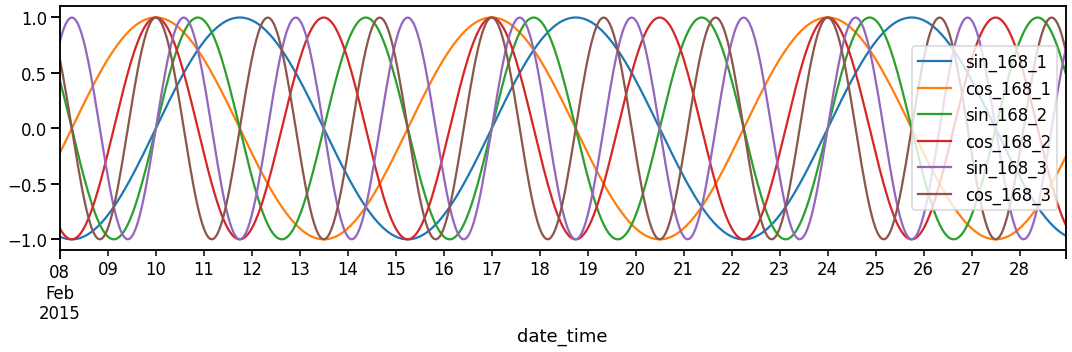

In [7]:
seasonal_period = 24*7

fig, ax = plt.subplots(figsize=(15,5))
result.filter(like=f"_{seasonal_period}_").iloc[-seasonal_period*3:].plot(ax=ax)
plt.tight_layout()

# Let's see how fourier features help capture seasonality.

Let's build a linear model using only fourier features to understand how they help capture seasonality.

The linear model being fit is: $$y_t = \sum_{p}\sum_{n=1}^{n_p} A_{n,p}sin(\frac{2\pi nt}{T_p}) + B_{n,p}cos(\frac{2\pi nt }{T_p})$$

where ...

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [10]:
fourier_feats = FourierFeatures(
                              sp_list = [24, # daily seasonality
                                         24*7, # weekly seasonality
                                         24*365, # yearly seasonality
                                        ], 
                              fourier_terms_list = [3, # daily seasonality
                                                    3, # weekly seasonality
                                                    3, # yearly seasonality
                                                   ], 
                              freq="H", 
                              keep_original_columns=False,
                             )

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/fourier.py:124: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


Split data into train and test.

In [11]:
# Hold out the last 4 weeks of obeservations 
holdout_size = 24*7*2
df_train = data.iloc[:-holdout_size]
df_test = data.iloc[-holdout_size:]

Creat fourier features.

In [12]:
X_train = fourier_feats.fit_transform(df_train)
y_train = df_train.loc[:, ["demand"]]

X_test = fourier_feats.transform(df_test)
y_test = df_test.loc[:, ["demand"]]

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=["demand"])

y_forecast_test = model.predict(X_test)
y_forecast_test = pd.DataFrame(y_forecast_test, index=X_test.index, columns=["demand"])

NameError: name 'target' is not defined

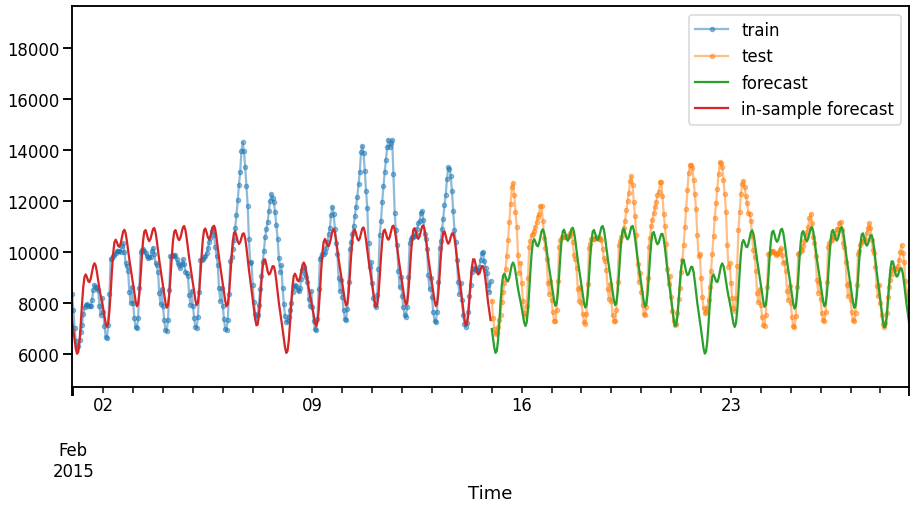

In [14]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[15, 7])

# Plot training set.
y_train.plot(ax=ax, marker='.', alpha=0.5)
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.5)
# Plot forecast in testing data.
y_forecast_test.plot(ax=ax)
# Plot forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=2))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

# Let's build some forecasts!

Let's build a recursive forecast and see how we can include datetime features in our feature engineering pipeline.

In [ ]:
# Fourier features to capture seasonality
from sktime.transformations.series.fourier import FourierFeatures
# Datetime features
from sktime.transformations.series.date import DateTimeFeatures
# Lag and window features
from sktime.transformations.series.summarize import WindowSummarizer
# Time features for trend 
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
# Rescaling transformer for linear models with regularisation
from sklearn.preprocessing import MinMaxScaler
# Pipelines to create feature engineering pipeline
from sklearn.pipeline import make_pipeline, make_union
# Used to reset sklearn estimators
from sklearn.base import clone

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
                                       # for this feature

In [ ]:
df = data.copy()
df.head()

Specify target name.

In [ ]:
target=["demand"] # Note: it's in a list.
                  # This ensures we'll get
                  # a dataframe when using df.loc[:, target]
                  # rather than a pandas Series. 
                  # This can also be useful if we have
                  # multiple targets.

Prepare our transformers.

In [ ]:
# Polynomial time features for trend
time_feats = make_pipeline(
                           TimeSince(), 
                           PolynomialFeatures(degree=1, include_bias=False)
                          )

# Datetime features
# Specify which datetime features to create
datetime_features = [
                       "is_weekend",
                    ]

datetime_feats = DateTimeFeatures(ts_freq="H",
                               manual_selection=datetime_features, 
                               keep_original_columns=False, 
                              )

# Create the fourier features
fourier_feats = FourierFeatures(
                              sp_list = [24, 24*7, 24*365], 
                              fourier_terms_list = [3, 3, 3], 
                              freq="H", 
                              keep_original_columns=False,
                             )


# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": np.arange(1, 25),  # Lag features.
        "mean": [[1, 24], [1, 24*7]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features.

In [ ]:
pipeline = make_union(
    datetime_feats,
    fourier_feats,
    time_feats, 
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [ ]:
pipeline

Let's check how our feature engineering pipeline behaves.

In [ ]:
pipeline.fit_transform(df.head())

Let's reset our feature engineering pipeline.

In [ ]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

We'll start with configuring the model, the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor

In [ ]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.                                              
forecast_start_time = df.index.max() - pd.DateOffset(weeks=2) # Start two weeks from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 24*7*2 

# Define the model.
model = Ridge(alpha=0.1)

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(forecast_start_time, 
                                   periods=num_of_forecast_steps,
                                   freq="H")

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(weeks=1) # We need the latest 24*7 time periods
                                             # in our predict dataframe to build our 
                                             # window features.

Let's create our training dataframe.

In [ ]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Let's prepare the dataframe that we will pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data.

In [ ]:
# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which have
# certain characters (e.g., ":"). We replace these
# with `_`. 
if "lightgbm" in model.__module__: # checks if model is from lightgbm
    X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))


# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

In [ ]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this 
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period 
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
                  df_predict,
                  pd.DataFrame(index=forecast_horizon)
                 ])

Let's compute our `X_train` and `y_train` and fit our model!

Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [ ]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:    
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]] 

    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_predict`. This `df_predict`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

Let's retrieve our forecast and actuals during the forest horizon.

In [ ]:
# --- GET FORECAST AND TEST VALUES --- #    
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

Let's create predictions on the training set using our one step ahead forecast model. This is useful to plot when debugging models.

In [ ]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Let's plot the forecast!

In [ ]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[12, 7])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=3))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's compute the RMSE of this forecast.

In [ ]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=y_test.loc[y_forecast.index],
                   y_pred=y_forecast,
                   squared=False)

Feel free to change the dates, try different models, and different features!